In [22]:
%matplotlib widget
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:

dataH1 = pd.read_csv("GBPUSD_H1.csv")
dataM1 = pd.read_csv("GBPUSD_M1.csv")

dataH1['Time'] = pd.to_datetime(dataH1['Time']) # Convert time column to pd datetime
dataM1['Time'] = pd.to_datetime(dataM1['Time'])

(200000,)


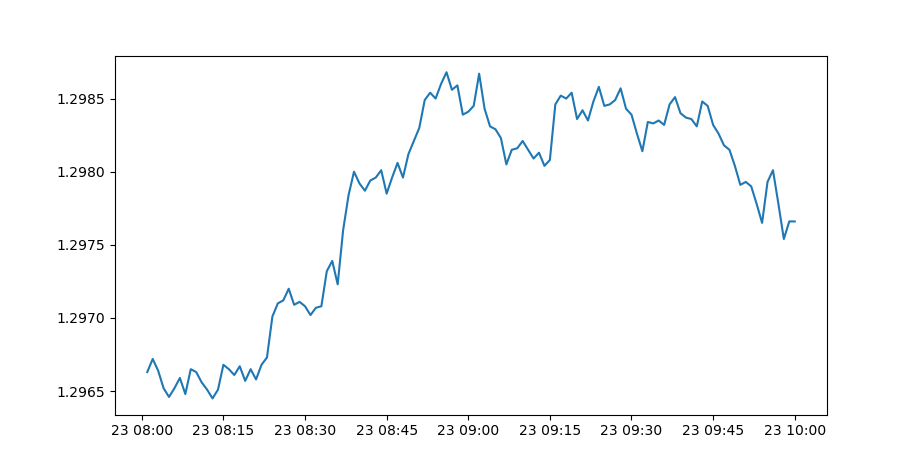

In [ ]:
plt.clf()

study_start = pd.to_datetime("2024-10-23 8:00")
study_length = 60 # minutes
study_end = study_start + pd.Timedelta(hours=study_length)

study_data = dataM1[(dataM1['Time'] > study_start) & (dataM1['Time'] <= study_end)]

plt.plot(study_data['Time'], study_data['Open'])
plt.show()

frame_window = 60 # minutes
frame_start = study_start - pd.Timedelta(minutes=frame_window)

kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, alpha=1, n_restarts_optimizer=0)

time_preds = []
y_preds = []
std_preds = []

for i in range(study_length):
    frame_data = dataM1[(dataM1['Time'] > frame_start + pd.Timedelta(minutes=i)) & (dataM1['Time'] <= study_start + pd.Timedelta(minutes=i))]
    frame_size = len(frame_data['Open'].values)
    
    X = np.arange(frame_size).reshape(-1, 1)
    y = frame_data['Close'].values.reshape(-1, 1)
    
    gpr.fit(X, y)
    
    X_pred = np.array([[frame_size - 1]])
    y_pred, std_pred = gpr.predict(X_pred, return_std=True)
    
    y_preds.append(y_pred)
    std_preds.append(std_pred)
    time_preds.append(frame_data['Time'].values[-1])

y_preds.append(y_preds[-1])
std_preds.append(std_preds[-1])
time_preds.append(time_preds[-1]+pd.Timedelta(hours=1))

y_preds = np.array(y_preds).flatten()
std_preds = np.array(std_preds).flatten()
time_preds = np.array(time_preds).flatten()

plt.step(time_preds, y_preds, where='post')

plt.fill_between(
    time_preds, 
    y_preds + 1.96 * std_preds, 
    y_preds - 1.96 * std_preds, 
    step='post',
    alpha=0.2,
    color='blue',
    label='95% Confidence Interval'
)


In [ ]:

frame_window = 100 # hours
frame_start = study_start - pd.Timedelta(hours=frame_window)

kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, alpha=1, n_restarts_optimizer=0)

time_preds = []
y_preds = []
std_preds = []

for i in range(study_length):
    frame_data = dataH1[(dataH1['Time'] > frame_start + pd.Timedelta(hours=i)) & (dataH1['Time'] <= study_start + pd.Timedelta(hours=i))]
    frame_size = len(frame_data['Open'].values)
    
    X = np.arange(frame_size).reshape(-1, 1)
    y = frame_data['Open'].values.reshape(-1, 1)
    
    gpr.fit(X, y)
    
    X_pred = np.array([[frame_size - 1]])
    y_pred, std_pred = gpr.predict(X_pred, return_std=True)
    
    y_preds.append(y_pred)
    std_preds.append(std_pred)
    time_preds.append(frame_data['Time'].values[-1])

y_preds.append(y_preds[-1])
std_preds.append(std_preds[-1])
time_preds.append(time_preds[-1]+pd.Timedelta(hours=1))

y_preds = np.array(y_preds).flatten()
std_preds = np.array(std_preds).flatten()
time_preds = np.array(time_preds).flatten()

plt.step(time_preds, y_preds, where='post')

plt.fill_between(
    time_preds, 
    y_preds + 1.96 * std_preds, 
    y_preds - 1.96 * std_preds, 
    step='post',
    alpha=0.2,
    color='blue',
    label='95% Confidence Interval'
)
